In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate


# Data analysis of Case 1
### By August Semrau and William Marstrand
This notebook consists of data preprocessing and analysis

In [47]:
### Load data
df_full = pd.read_excel('data/dataset.xls')
# df_full.columns = [c.strip().lower() for c in df_full.columns]
print('First 10 columns of the dataset:')
print(tabulate(df_full.head(20), headers='keys', tablefmt='plain'))

## Convert FlightNumber to object, it is not a numerical value
df_full.FlightNumber = df_full.FlightNumber.astype(object)
## Investigate data for dtypes and stuff
print('\ndtypes of the datasets columns:')
df_full.dtypes


First 10 columns of the dataset:
    ScheduleTime         Airline      FlightNumber  Destination    AircraftType    FlightType    Sector      SeatCapacity    LoadFactor
 0  2021-01-01 06:35:00  IA                    874  DEN            73W             J             US                   142     0.408451
 1  2021-01-01 10:35:00  JZ                    818  YHM            AT7             J             CA                    74     0.189189
 2  2021-01-01 12:05:00  IA                    876  DEN            73W             J             US                   142     0.570423
 3  2021-01-01 13:20:00  CN                    514  EST            AT7             J             US                    72     0.333333
 4  2021-01-01 14:20:00  LJ                   3140  DEN            32A             J             US                   186     0.204301
 5  2021-01-01 13:50:00  FP                    550  DXB            77W             J             AE                   428     0.231308
 6  2021-01-01 14:35:

ScheduleTime    datetime64[ns]
Airline                 object
FlightNumber            object
Destination             object
AircraftType            object
FlightType              object
Sector                  object
SeatCapacity             int64
LoadFactor             float64
dtype: object

#### Based on the different data types, we already know we want to do a couple of things to each column/feature, and these are described below:

#### For **ScheduleTime**, we want to do two things; Firstly, we want to convert the datetime64[ns] format to a more simple datetime format. We further want to create five new object columns, one which encodes which month of the year the flight is, which week, weekday, hour of day and minute of hour. These will also be encoded in the next step.

#### For **Airline**, **Flightnumber** (infact categorical), **Destination**, **Aircrafttype**, **Flighttype** and **Sector**, columns which are encoded as objects (they are categorical), we need to make an alternative encoding. If they hold few different classes, this is true for Flighttype which is either *J* or *C*, we will one-hot-encode them, else they will be label encoded. 

#### SeatCapacity is made categorical, though it differently from the rest, is in fact ordinal.

#### First, we remove rows with empty values

In [48]:
### Investigate for missing data
missing_values_count = df_full.isnull().sum()
print(f'List of null data counts for each column: \n{missing_values_count}')

## As there are so few missing values, a total of five rows, we simply remove these
df = df_full.dropna()
print(f'\nData had {df_full.shape[0]} rows pre-nan-removal, now has {df.shape[0]} rows.')

## Seperate data from target
X, y = df.loc[:, df.columns != 'LoadFactor'], df.loc[:, df.columns == 'LoadFactor']

List of null data counts for each column: 
ScheduleTime    0
Airline         1
FlightNumber    0
Destination     2
AircraftType    0
FlightType      0
Sector          2
SeatCapacity    0
LoadFactor      0
dtype: int64

Data had 36770 rows pre-nan-removal, now has 36768 rows.


## Preprocess **ScheduleTime**

In [53]:
### Preprosses time for getting year, month, week number, weekday, hour of day and minute of hour
X['Year'] = X['ScheduleTime'].dt.year
X['Month'] = X['ScheduleTime'].dt.month
X['WeekNumber'] = X['ScheduleTime'].dt.isocalendar().week % 52;
X['Weekday'] = X['ScheduleTime'].dt.dayofweek + 1;
X['HourOfDay'] = X['ScheduleTime'].dt.hour
X['MinuteOfHour'] = X['ScheduleTime'].dt.minute

X.Year = X.Year.astype(object)
X.Month = X.Month.astype(object)
X.WeekNumber = X.WeekNumber.astype(object)
X.Weekday = X.Weekday.astype(object)
X.HourOfDay = X.HourOfDay.astype(object)
X.MinuteOfHour = X.MinuteOfHour.astype(object)

X

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,Year,Month,WeekNumber,Weekday,HourOfDay,MinuteOfHour
0,2021-01-01 06:35:00,IA,874,DEN,73W,J,US,142,2021,1,1,5,6,35
1,2021-01-01 10:35:00,JZ,818,YHM,AT7,J,CA,74,2021,1,1,5,10,35
2,2021-01-01 12:05:00,IA,876,DEN,73W,J,US,142,2021,1,1,5,12,5
3,2021-01-01 13:20:00,CN,514,EST,AT7,J,US,72,2021,1,1,5,13,20
4,2021-01-01 14:20:00,LJ,3140,DEN,32A,J,US,186,2021,1,1,5,14,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36765,2022-02-08 18:30:00,VW,986,YYZ,320,J,CA,180,2022,2,6,2,18,30
36766,2022-02-08 19:30:00,LJ,579,YQU,319,J,CA,156,2022,2,6,2,19,30
36767,2022-02-08 19:40:00,LJ,506,YUL,319,J,CA,156,2022,2,6,2,19,40
36768,2022-02-08 19:05:00,CL,2708,DAN,73H,J,US,189,2022,2,6,2,19,5


## Preprocess categorical features

In [32]:
### We need to find out how many categorical values exist for each feature
X.describe(include = ['int64','object'])


,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,Year,Month,WeekNumber,Weekday,HourOfDay,MinuteOfHour
count,36768,36768.0,36768,36768,36768,36768,36768.000000,36768.0,36768.0,36768.0,36768.0,36768.0,36768.0
unique,95,807.0,230,56,3,12,NaN,2.0,12.0,52.0,7.0,23.0,13.0
top,DO,771.0,CKE,73H,J,CA,NaN,2021.0,10.0,1.0,7.0,7.0,40.0
freq,9808,341.0,2570,8316,35642,17906,NaN,32348.0,4705.0,1427.0,6025.0,2774.0,3133.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,155.286091,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,58.852431,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,98.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,180.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,189.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
### Make one-hot-encodings for the columns which have few categories

## All categorical features
X_dummy = pd.get_dummies(data=X)
X_dummy

# ## Only up to 15 different values per category
# X_dummy = pd.get_dummies(data=X, columns=['FlightType', 'Sector', 'Year', 'Month', 'Weekday', 'MinuteOfHour'])
# X_dummy

,ScheduleTime,SeatCapacity,Airline_AY,Airline_BJ,Airline_BT,Airline_BZ,Airline_CL,Airline_CN,Airline_DO,Airline_DT,...,MinuteOfHour_15,MinuteOfHour_20,MinuteOfHour_25,MinuteOfHour_30,MinuteOfHour_35,MinuteOfHour_40,MinuteOfHour_45,MinuteOfHour_50,MinuteOfHour_54,MinuteOfHour_55
0,2021-01-01 06:35:00,142,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2021-01-01 10:35:00,74,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2021-01-01 12:05:00,142,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-01 13:20:00,72,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,2021-01-01 14:20:00,186,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36765,2022-02-08 18:30:00,180,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
36766,2022-02-08 19:30:00,156,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
36767,2022-02-08 19:40:00,156,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
36768,2022-02-08 19:05:00,189,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
### Encoding Seat Capacity
X.SeatCapacity = X.SeatCapacity.astype(object)

# Plotting data

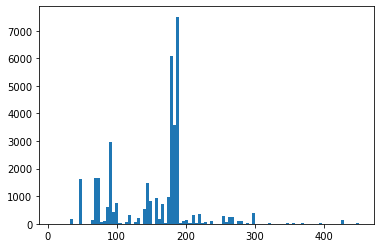

In [26]:
plt.hist(X_dummy.SeatCapacity, bins=100);

# It all in one pipeline


In [57]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Read data and drop nan's
df_full = pd.read_excel('data/dataset.xls')
df_full.FlightNumber = df_full.FlightNumber.astype(object)
# df_full.SeatCapacity = df_full.SeatCapacity.astype(object)
df = df_full.dropna()

## Split time into usable data
df['Year'] = df.ScheduleTime.dt.year.astype(object);
df['Month'] = df['ScheduleTime'].dt.month.astype(object);
df['WeekNumber'] = df['ScheduleTime'].dt.isocalendar().week % 52;
df['Weekday'] = df['ScheduleTime'].dt.dayofweek + 1;
df.WeekNumber = df.WeekNumber.astype(object);
df.Weekday = df.Weekday.astype(object);
df['HourOfDay'] = df['ScheduleTime'].dt.hour.astype(object);
df['MinuteOfHour'] = df['ScheduleTime'].dt.minute.astype(object);

## Define feature columns
feature_cols = ['Airline', 'FlightNumber', 'Destination', 'AircraftType', 'FlightType', 'Sector', 'SeatCapacity', 'Year', 'Month', 'WeekNumber', 'Weekday', 'HourOfDay', 'MinuteOfHour']
under_15_cols = ['FlightType', 'Sector', 'Year', 'Month', 'Weekday', 'MinuteOfHour']
over_15_cols = ['Airline', 'FlightNumber', 'Destination', 'AircraftType', 'WeekNumber', 'HourOfDay']
nominal_cols = ['Airline', 'FlightNumber', 'Destination', 'AircraftType', 'FlightType', 'Sector', 'Year', 'Month', 'WeekNumber', 'Weekday', 'HourOfDay', 'MinuteOfHour']
ordinal_cols = ['SeatCapacity']

## Split target from feature data
X = df[feature_cols]
y = df['LoadFactor']

## Encode features with one-hot-encoding
# X = pd.get_dummies(data=X, columns=under_15_cols)
X = pd.get_dummies(data=X, columns=nominal_cols);
X

,SeatCapacity,Airline_AY,Airline_BJ,Airline_BT,Airline_BZ,Airline_CL,Airline_CN,Airline_DO,Airline_DT,Airline_DU,...,MinuteOfHour_15,MinuteOfHour_20,MinuteOfHour_25,MinuteOfHour_30,MinuteOfHour_35,MinuteOfHour_40,MinuteOfHour_45,MinuteOfHour_50,MinuteOfHour_54,MinuteOfHour_55
0,142,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,74,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,142,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,72,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,186,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36765,180,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
36766,156,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
36767,156,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
36768,189,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# Extra

In [ ]:
from category_encoders import TargetEncoder
encoder = TargetEncoder()
X_dummy2 = X
X_dummy2['Animal Encoded'] = encoder.fit_transform(X_dummy2['FlightNumber'], df['LoadFactor'])
X_dummy2